### 数据解压命令 shell 脚本 unzip_data.sh
```bash
# unzip_data.sh 内容 数据压缩文件所在目录为 data_weather， 解压目录为 weather
unzip -q data_weather/weather_round1_train_2007.zip -d weather
unzip -q data_weather/weather_round1_train_2008.zip -d weather
unzip -q data_weather/weather_round1_train_2009.zip -d weather
unzip -q data_weather/weather_round1_train_2010.zip -d weather
unzip -q data_weather/weather_round1_train_2011.zip -d weather
unzip -q data_weather/weather_round1_test.zip -d weather
```

### 安装所需依赖 并创建所需目录 shell 脚本 depes_install.sh
```bash
# depes_install.sh 内容
pip install -q importlib-metadata==4.13.0
pip install -q zarr lightgbm catboost
pip install -q xarray[complete]
mkdir model output
```

In [ ]:
# 若未进行数据解压和依赖的安装,执行上述两个脚本
! bash ./unzip_data.sh
! bash ./depes_install.sh

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from collections import defaultdict, Counter
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold
from sklearn.metrics import mean_squared_error
from joblib import Parallel, delayed
from tqdm.auto import tqdm
import os
import sys,os,gc,argparse,warnings,torch,glob
warnings.filterwarnings('ignore')

In [2]:
path = './weather/'
# 如果不是 dask array，按时刻进行分块转换为 dask array
def chunk_time(ds):
    dims = {k:v for k, v in ds.dims.items()}
    dims['time'] = 1
    ds = ds.chunk(dims)
    return ds
# 数据载入
def load_dataset():
    ds = []
    for y in range(2007, 2012):
        data_name = os.path.join(path, f'weather_round1_train_{y}')
        x = xr.open_zarr(data_name, consolidated=True)
        print(f'{data_name}, {x.time.values[0]} ~ {x.time.values[-1]}')
        ds.append(x)
    ds = xr.concat(ds, 'time')
    ds = chunk_time(ds)
    return ds

ds = load_dataset().x # 载入的数据集中含有其他信息，x是 array 形式的数据

./weather/weather_round1_train_2007, 2007-01-01T00:00:00.000000000 ~ 2007-12-31T18:00:00.000000000
./weather/weather_round1_train_2008, 2008-01-01T00:00:00.000000000 ~ 2008-12-31T18:00:00.000000000
./weather/weather_round1_train_2009, 2009-01-01T00:00:00.000000000 ~ 2009-12-31T18:00:00.000000000
./weather/weather_round1_train_2010, 2010-01-01T00:00:00.000000000 ~ 2010-12-31T18:00:00.000000000
./weather/weather_round1_train_2011, 2011-01-01T00:00:00.000000000 ~ 2011-12-31T18:00:00.000000000


### 构建训练样本
测试数据中仅给出两个时刻的气候数据，目标是预测后面20个时刻的气候数据。所以训练时也要按照相同的模式，一次使用22个连续时刻作为一份训练样本，array 的维度应为 22 × 70 × 161 × 161。

之后要转换为 特征空间 中的样本点，维度为 时刻 × 经度 × 纬度 × 输入大气特征 ... × 预测大气特征 ... = time × lat × lon × feat0 × ... × featn × t2m × u10 × v10 × msl × tp

In [3]:
# 空间坐标 161 × 161 个位置坐标 ——> 解决上述中的经度和纬度两个特征
lats = ds.lat.values.tolist()
lons = ds.lon.values.tolist()
# 经纬度相互组合，作为特征空间中样本点的两个维度
coords = []
for i in range(161):
    for j in range(161):
        coords.append([lats[i], lons[j]])
coords = np.array(coords) # shape (161*161,2)

In [4]:
'''
    对齐测试数据，每份数据应该是22个时刻
    总共 7304 个时刻的大气数据，最后 5 个不重叠区间 作为训练样本 一个区间 22 个时刻
'''
n = 5
train_data = []
# start_indx = list(range(7170,7280,22))
# for i,st in enumerate(start_indx):
#     samp_data = ds[i:i+22,...]
#     train_data.append(samp_data.values)
#     print(f'{i+1}/{n} data block is finished',end='\r')

for i in range(n):
    if i == 0:
        train_data.append(ds[-22:, :, :, :].values)
    else:
        idx = i * 24
        train_data.append(ds[-22-idx:-idx, :, :, :].values)
    print(f'{i+1}/{n} data block is finished',end='\r')

In [5]:
'''
    转换并提取大气特征，
    使用 前两个 时刻的所有大气特征和特征工程构造的特征 作为输入特征，
    让模型拟合后20个时刻的 5 个需要预测的特征
'''
for flag, dat in enumerate(train_data):
    # 前两个时刻特征及其差分特征 将原本的在空间网格上的特征 转换为一个一个的特征向量 70 × 161 × 161 -> 161*161 = 25,921 × 70
    first_feat = dat[0,:,:,:].reshape(70,161*161).transpose()
    second_feat = dat[1,:,:,:].reshape(70,161*161).transpose()
    diff_feat = (dat[1,:,:,:] - dat[0,:,:,:]).reshape(70,161*161).transpose()
    # 将位置特征 和 前两个时刻的特征及其差分特征合并为历史特征 25,921 × (2+70+70+70)
    hist_feat = np.concatenate((coords,first_feat,second_feat,diff_feat),axis=1) # shape: (161*161,212)
    
    # 后面 20 个时刻需要预测的特征提取 20 × 5 × 161 × 161 -> 20 × 25,921 × 5
    tmp_dat = dat[2:,-5:,:,:] # shape: (20, 5, 161, 161)
    nt,nf,nc1,nc2 = tmp_dat.shape
    tmp_dat = tmp_dat.reshape(nt,nf,nc1*nc2).transpose(0,2,1) # shape: (20,161*161,5)
    
    for i in range(20):
        # 时间特征
        sub_vals = np.array([i]*161*161).reshape(161*161,1) # shape: (161*161,1)
        # 添加历史特征
        sub_vals = np.concatenate((sub_vals, hist_feat), axis=1) # shape: (161*161,213)
        # 添加5个目标变量
        sub_vals = np.concatenate((sub_vals, tmp_dat[i,...]), axis=1) # shape: (161*161,218)
        if i == 0 :
            all_vals = sub_vals
        else:
            all_vals = np.concatenate((all_vals, sub_vals), axis=0)

    print(f'{flag+1}/{n} extracting and recomposing features',end='\r')
    if flag == 0:
        final_vals = all_vals
    else:
        final_vals = np.concatenate((final_vals,all_vals),axis=0)

In [6]:
''' 将整理好的特征向量集合重新使用 dataframe 进行存放，
    特征包括：时间，2个空间（经度和纬度）坐标，
    前两个时刻原有的70×2个大气特征和特征工程产生的70个两时刻之间的差分特征，
    5个需要预测的大气特征
'''
input_features = ['time','lat','lon'] + [f'feat_{i}' for i in range(210)]
predict_features = ['t2m','u10','v10','msl','tp']
data_df = pd.DataFrame(final_vals)
data_df.columns = input_features + predict_features

### 训练模型并保存

使用 K 折交叉验证，k = 5。将 所有数据（特征向量集合） 分为 5 个组，每次使用其中一个组作为验证集，其他四组分为训练集。
机器学习模型使用 Catboost

In [7]:
def train_model(data_df, params, label,seed=2023):
    kf = KFold(n_splits=5, shuffle=True, random_state=seed) # K 折交叉验证 k=5 采样器
    cv_scores = {}
    
    for i, (train_index, valid_index) in enumerate(kf.split(data_df)): # 抽取数据进行 K 折交叉验证,每轮交叉验证会训练好一个模型并保存
        cv_scores[i] = []
        # 模型初始化
        model = CatBoostRegressor(iterations=100,**params)
        # 载入训练集并对模型进行训练
        trn_x, trn_y = data_df.iloc[train_index][input_features].values, data_df.iloc[train_index][[label]].values
        val_x, val_y = data_df.iloc[valid_index][input_features].values, data_df.iloc[valid_index][[label]].values
        model.fit(trn_x, trn_y,
                  eval_set = (val_x,val_y),
                  verbose=False)
        # 模型保存
        model.save_model(f'model/catboost_{label}_fold{i}.model')
        print(f'Predict feature: {label}  KFold: {i:02} model has been saved.')
        # 载入验证集并记录验证结果
        val_pred_y  = model.predict(val_x)
        tmp_score = np.sqrt(mean_squared_error(val_y, val_pred_y))
        cv_scores[i].append(tmp_score)
        print(f'Predict feature: {label}  Kfold seed: {seed}  KFlod: {i:02}  cv_score: {cv_scores[i][-1]:.4f}')

In [8]:
# 模型参数
params = {
    'learning_rate': 0.5,
    'depth': 6,
    'bootstrap_type':'Bernoulli',
    'random_seed':11,
    'od_type': 'Iter',
    'od_wait': 100,
    'allow_writing_files': False,
    'task_type':"GPU",
    'devices':'0:1',
    'use_best_model':True
}

In [9]:
# 对每个预测变量训练 5 个模型
for label in ['t2m','u10','v10','msl','tp']:
    print(f'==================== {label} ====================')
    train_model(data_df, params, label)

==================== t2m ====================
Predict feature: t2m  KFold: 00 model has been saved.
Predict feature: t2m  Kfold seed: 2023  KFlod: 00  cv_score: 0.2436
Predict feature: t2m  KFold: 01 model has been saved.
Predict feature: t2m  Kfold seed: 2023  KFlod: 01  cv_score: 0.2433
Predict feature: t2m  KFold: 02 model has been saved.
Predict feature: t2m  Kfold seed: 2023  KFlod: 02  cv_score: 0.2414
Predict feature: t2m  KFold: 03 model has been saved.
Predict feature: t2m  Kfold seed: 2023  KFlod: 03  cv_score: 0.2444
Predict feature: t2m  KFold: 04 model has been saved.
Predict feature: t2m  Kfold seed: 2023  KFlod: 04  cv_score: 0.2432
==================== u10 ====================
Predict feature: u10  KFold: 00 model has been saved.
Predict feature: u10  Kfold seed: 2023  KFlod: 00  cv_score: 0.5028
Predict feature: u10  KFold: 01 model has been saved.
Predict feature: u10  Kfold seed: 2023  KFlod: 01  cv_score: 0.5022
Predict feature: u10  KFold: 02 model has been saved.


In [10]:
# 删除无用变量 释放内存
del first_feat
del second_feat
del diff_feat
del hist_feat
del data_df
del final_vals

### 预测结果

In [11]:
def get_test_data(dat):
    # 第一时刻特征,第二时刻特征,两个时刻差分特征 (70, 161, 161) -> (161*161, 70)
    first_feat = dat[0,:,:,:].reshape(70,161*161).transpose()
    second_feat = dat[1,:,:,:].reshape(70,161*161).transpose()
    diff_feat = (dat[1,:,:,:] - dat[0,:,:,:]).reshape(70,161*161).transpose()
    hist_feat = np.concatenate((coords,first_feat,second_feat,diff_feat),axis=1) # shape: (161*161,212)
    
    # 构建测试样本
    for i in range(20): # 20个时刻
        # 时间特征
        sub_vals = np.array([i]*161*161).reshape(161*161,1) #（161*161，1）
        # 添加历史特征: 空间位置坐标（经纬度），第一时刻特征、第二时刻特征、两个时刻差分特征
        sub_vals = np.concatenate((sub_vals, hist_feat), axis=1) # (161*161,213)
        if i == 0 :
            all_vals = sub_vals
        else:
            all_vals = np.concatenate((all_vals, sub_vals), axis=0)
            
    df = pd.DataFrame(all_vals)
    df.columns = ['time','lat','lon'] + [f'feat_{i}' for i in range(210)]
    return df

In [12]:
def inter_model(test_x, label, seed=2023):
    n_splits = 5
    test = np.zeros(test_x.shape[0])
    
    params = {'learning_rate': 0.5,
              'depth': 6,
              'bootstrap_type':'Bernoulli',
              'random_seed':11,
              'metric_period': 300,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False,
              # 'task_type': 'CPU',
              'task_type':"GPU",
              'devices':'0:1'}

    for i in range(0, 5):
        model = CatBoostRegressor(**params) 
        # 载入已经训练好的模型
        model.load_model(f'model/catboost_{label}_fold{i}.model')
        test_pred = model.predict(test_x)
        test += test_pred 
    test /= n_splits   
    return test

def get_result(file):
    # print(f'load data {file}')
    input_data = torch.load(file)
    test_df = get_test_data(np.array(input_data)) # 生成测试样本，并构建特征
    res = test_df[['time']] # 保存结果
    
    # print('Start predicting features')
    for label in ['t2m','u10','v10','msl','tp']:
        cat_pred = inter_model(test_df[cols].copy().values, label) # 模型推理，预测测试集结果
        res[label] = cat_pred
    # print('Start transfering data format')
    # 转为提交格式
    for label in ['t2m','u10','v10','msl','tp']:
        for i in range(20):
            sub_vals = res[res['time']==i][label].values.reshape(1,161,161)
            if i == 0:
                all_vals = sub_vals
            else:
                all_vals = np.concatenate((all_vals, sub_vals), axis=0)
        all_vals = all_vals.reshape(20,1,161,161)
        
        if label == 't2m':
            final_vals = all_vals
        else:
            final_vals = np.concatenate((final_vals, all_vals), axis=1)
    # print('Store results')
    final_vals = torch.tensor(final_vals)
    save_file = file.split('/')[-1]
    torch.save(final_vals.half(), f'output/{save_file}', ) # 精度转为半精度浮点类型

In [13]:
cols = ['time','lat','lon'] + [f'feat_{i}' for i in range(210)]
pred_files = [f'{path}/weather_round1_test/input/{i}' for i in os.listdir(f'{path}/weather_round1_test/input/')]
n = len(pred_files)

In [14]:
# Parallel(n_jobs=2)(
#     delayed(get_parallel_result)(file_path)
#       for file_path in glob.glob(f'{path}/weather_round1_test/input/*.pt')
# )

In [16]:
for i,fp in enumerate(pred_files):
    get_result(fp)
    print(f'{i+1:03}/{n} tasks have been finished',end='\r')

# 输出结果

In [17]:
import zipfile,os
path='./output/' #压缩当前路径所有文件，输出zip文件
zipName = 'output.zip' #压缩后文件的位置及名称
f = zipfile.ZipFile( zipName, 'w', zipfile.ZIP_DEFLATED )
i = 0
for dirpath, dirnames, filenames in os.walk(path):
    for filename in filenames:
        i += 1
        print(f'{filename} has been zipped  {i:03}/{300}',end='\r')
        f.write(os.path.join(dirpath,filename))
f.close()

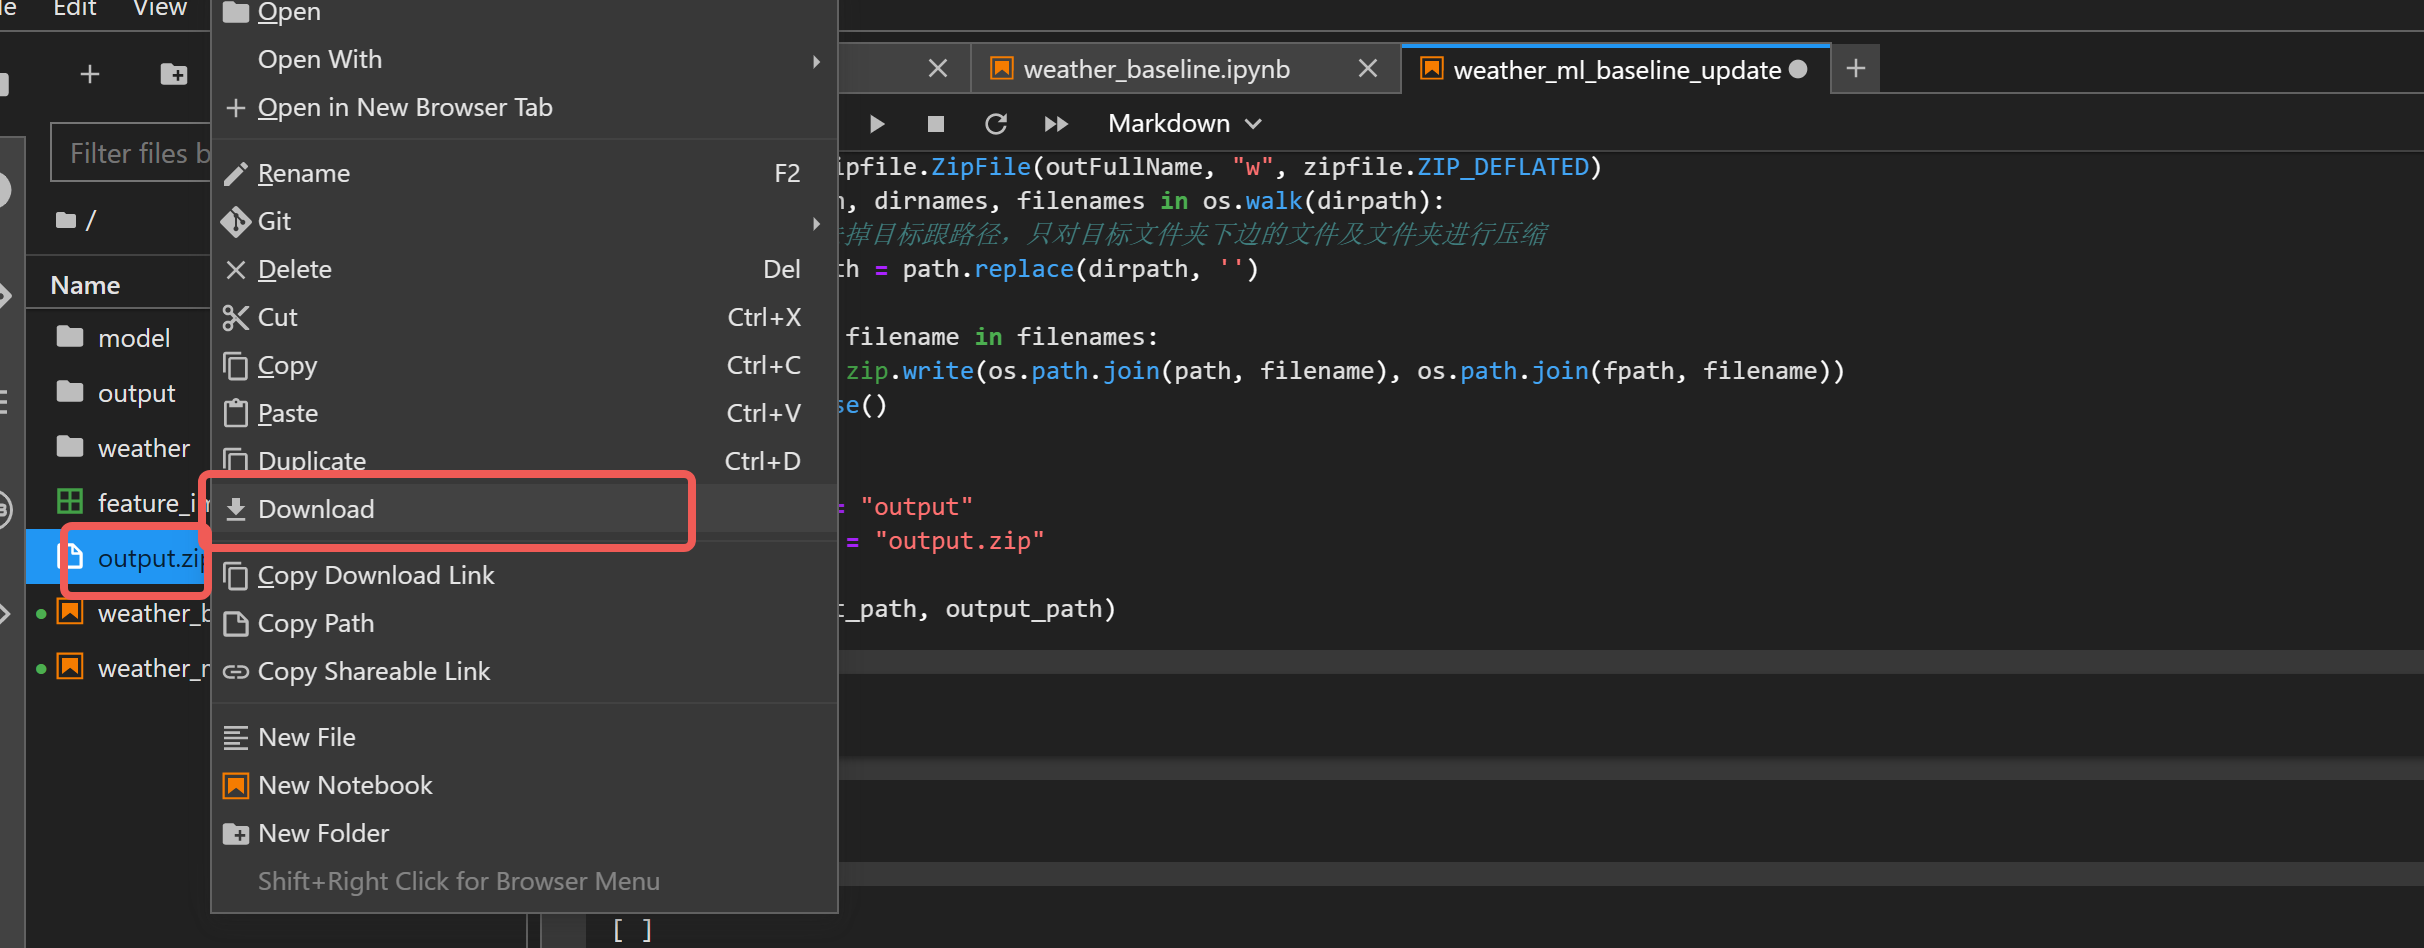# 获得成绩
## 下载结果文件
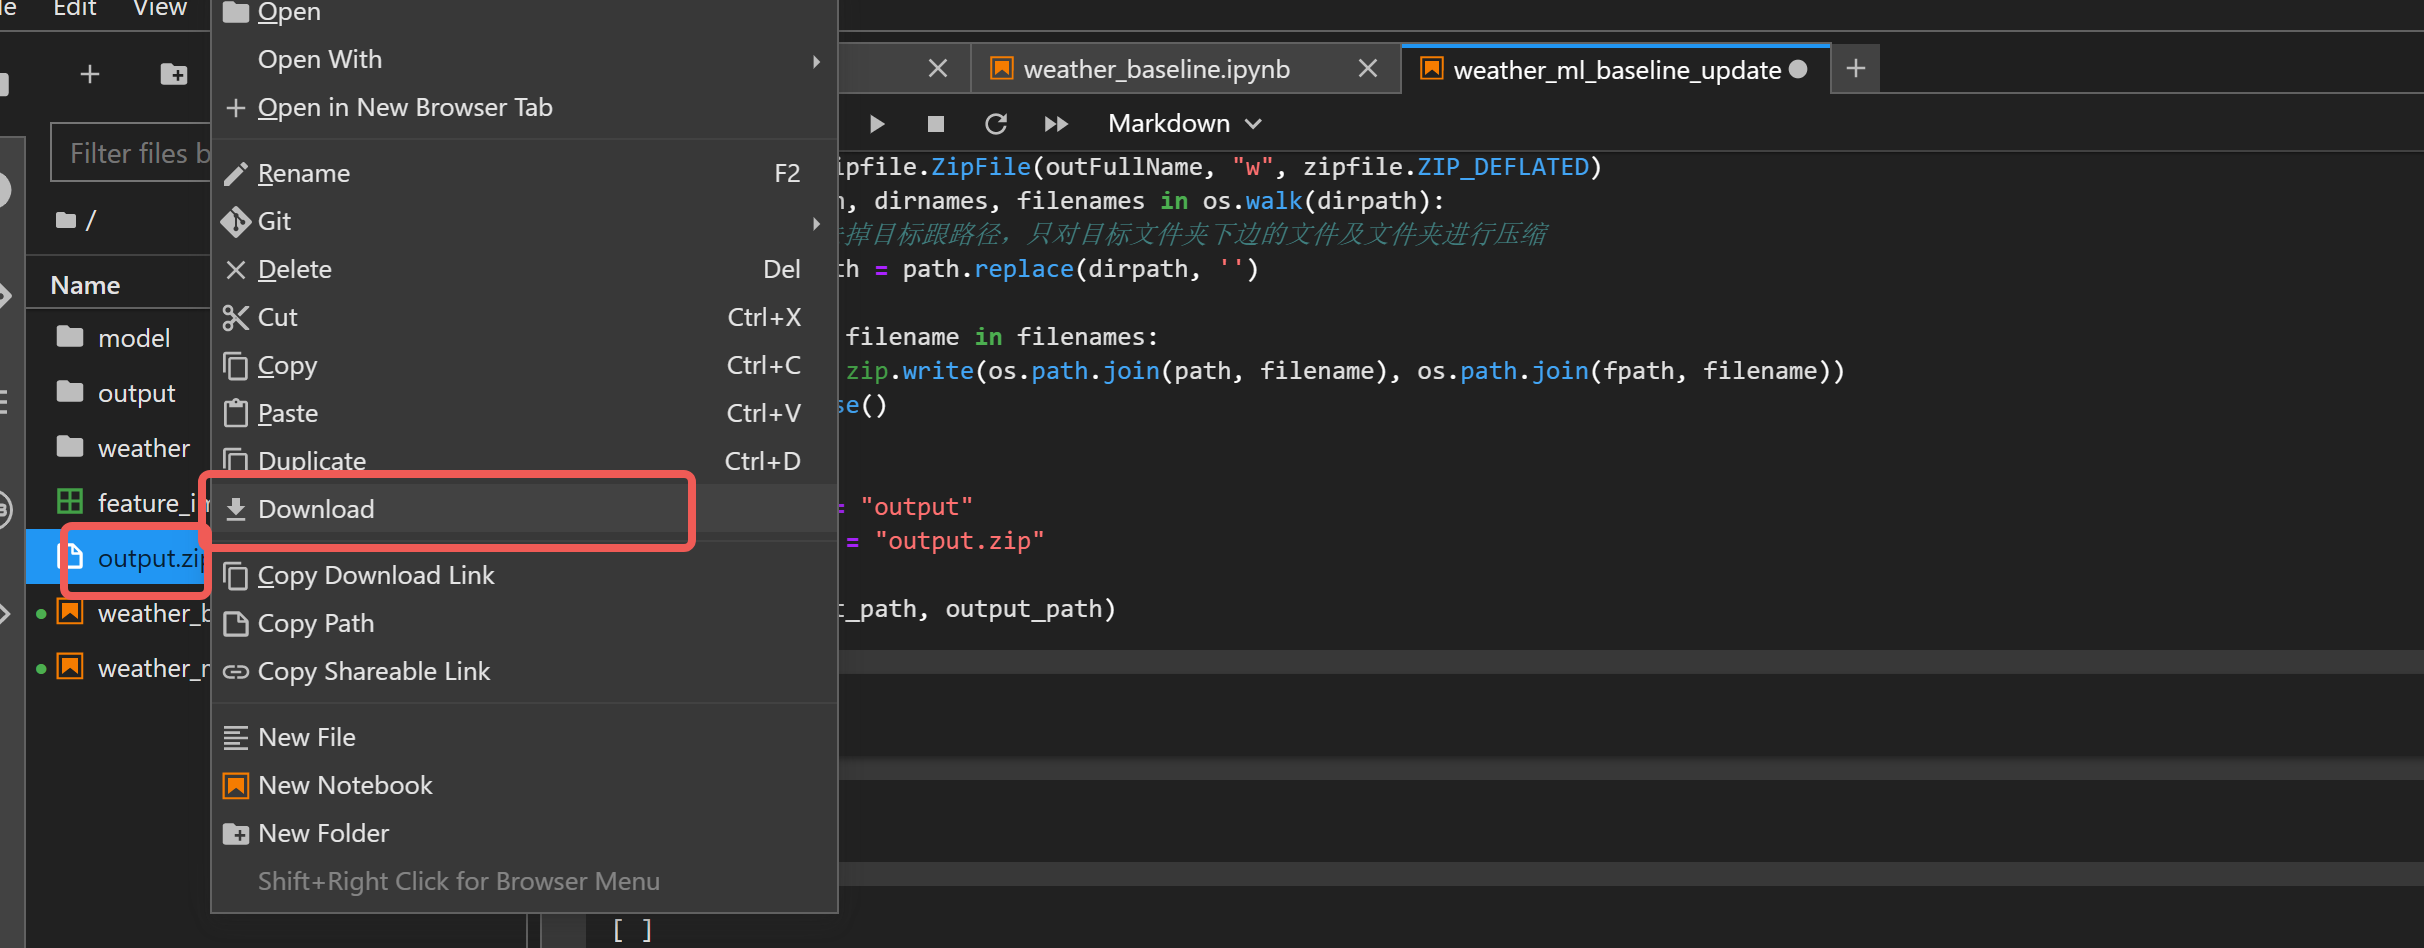

如果下载输出压缩包快完成报网络错误：参考文档中的方法来解决：https://xqbbve5hpvs.feishu.cn/docx/DiooduxPHoCbv4xk5atc9Td5npe#BbDFdMvJboqFntxfI3TcxkZDnOe

## 提交结果
点击【提交结果】，上传刚下载的output.zip文件
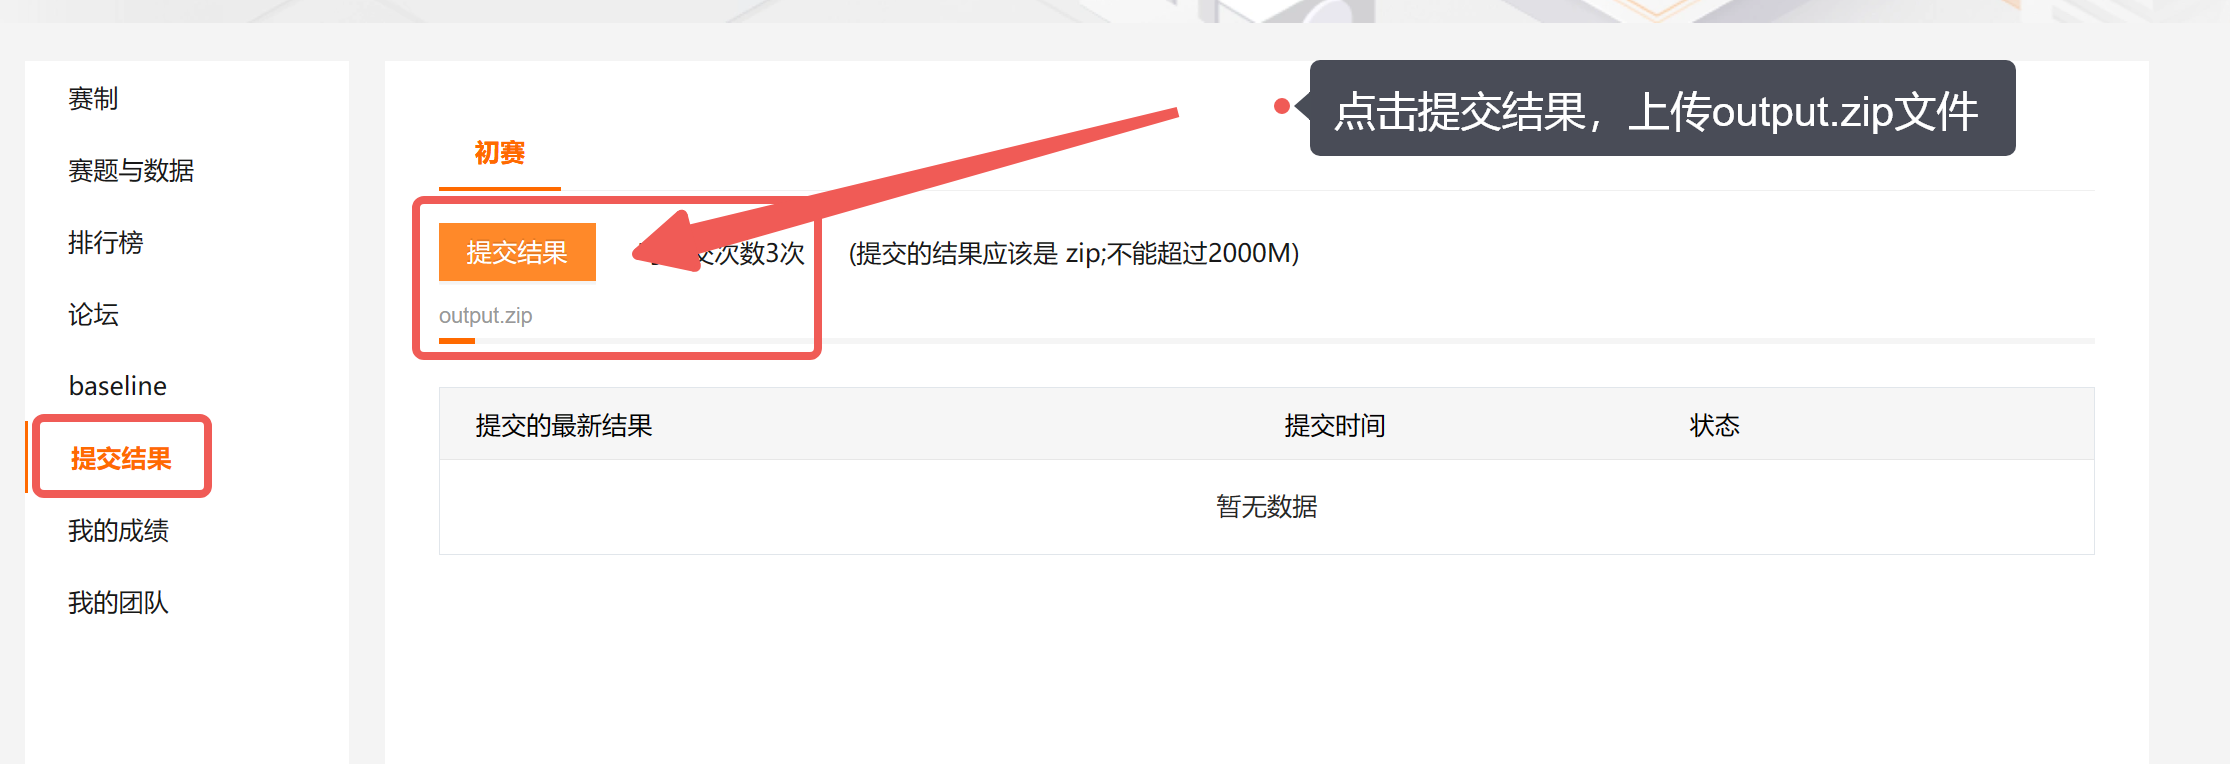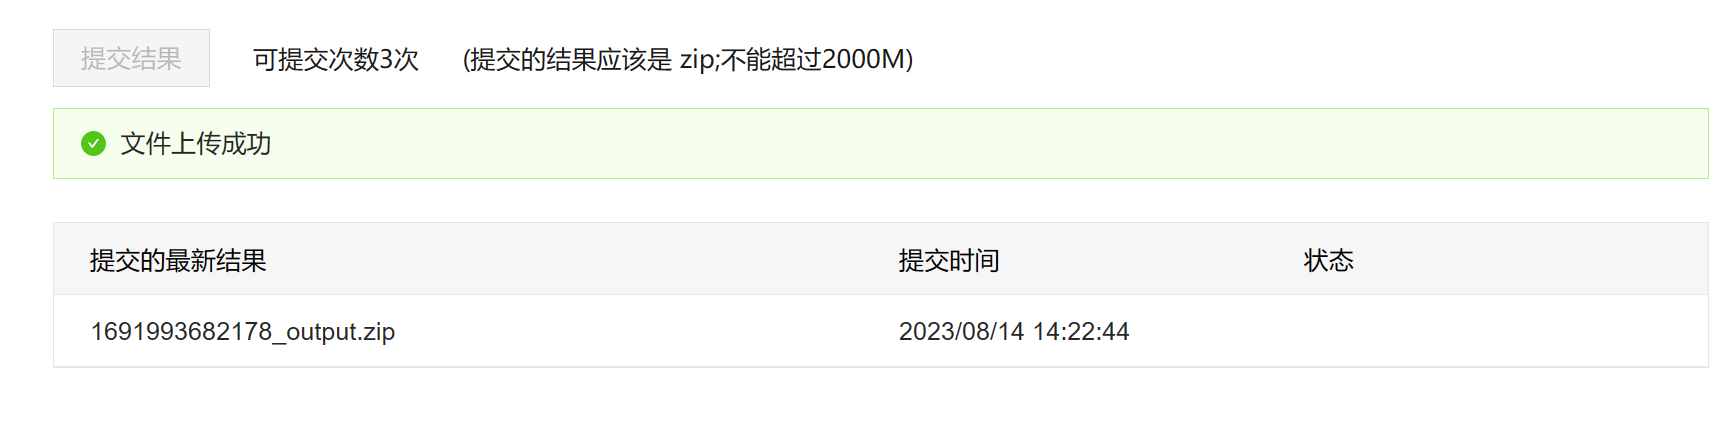
